In [701]:
%matplotlib inline  
import numpy as np 
import pandas as pd 
import pylab as pl 
import datetime as dt 
import os 
from wmf import wmf 
from multiprocessing import Pool
import matplotlib
import MySQLdb
import json
from cpr import cpr
import pickle
import alarmas as al
import funciones_sora
#Ignorar avisos pendejos
import warnings
warnings.filterwarnings('ignore')
import funciones_sora as fs
import glob

Funciones

In [2]:
def getInfoestIndatos(est_codes):
    codeest=est_codes[0]
    # coneccion a bd con usuario operacional
    host   = '192.168.1.74'
    user   = 'siata_Oper'
    passwd = 'si@t@64512_operacional'
    bd     = 'siata'
    #Consulta a tabla estaciones
    Estaciones="SELECT codigo,longitude,latitude,nombreestacion,fechainstalacion  FROM estaciones WHERE codigo=("+str(codeest)+")"
    dbconn = MySQLdb.connect(host, user,passwd,bd)
    db_cursor = dbconn.cursor()
    db_cursor.execute(Estaciones)
    result = np.array(db_cursor.fetchall())
    estaciones_datos_all=pd.DataFrame(result,columns=['codigo','longitud','latitud','nombreestacion','fechainstalacion'])


    for ind,est in enumerate(est_codes[1:]):
        try:
            # codigo de la estacion.
            codeest=est
            # coneccion a bd con usuario operacional
            host   = '192.168.1.74'
            user   = 'siata_Oper'
            passwd = 'si@t@64512_operacional'
            bd     = 'siata'
            #Consulta a tabla estaciones
            Estaciones="SELECT codigo,longitude,latitude,nombreestacion,fechainstalacion  FROM estaciones WHERE codigo=("+str(codeest)+")"
            dbconn = MySQLdb.connect(host, user,passwd,bd)
            db_cursor = dbconn.cursor()
            db_cursor.execute(Estaciones)
            result = np.array(db_cursor.fetchall())
            #holding
            estaciones_datos=pd.DataFrame(result,columns=['codigo','longitud','latitud','nombreestacion','fechainstalacion'])
            estaciones_datos_all=estaciones_datos_all.append(estaciones_datos)
        except:
            pass
    estaciones_datos_all.index=estaciones_datos_all['codigo']
    estaciones_datos_all.index.name=''
    estaciones_datos_all=estaciones_datos_all.drop('codigo',axis=1)
    return estaciones_datos_all

Estaciones

In [3]:
rutaconfig='/media/nicolas/Home/Jupyter/Soraya/git/Alarmas/04_web_hidrologia/hidrologia/informacion_sirenas.md'
listconfig=al.get_rutesList(rutaconfig)
dfconfig=pd.read_json(al.get_ruta(listconfig,'ruta_JSONinfosirenas'))
dfconfig

,EstMeteoAdentro,EstMeteoAfuera,EstN30m,EstNivel,EstNivel1,EstPluvioAdentro,EstPluvioAfuera,EstTto,Nombres Alarmas,Nombres Corriente Asociada,URL Cuencas
,,,,[155],[155],,"[37, 74]",,EL HATO,EL HATO,NaN
216,[197],[249],[108],"[90, 108]",[108],"[3, 18, 43]",,,SIRENA SANTA RITA SAN ANTONIO DE PRADO,Q. DONA MARIA,NaN
219,,[249],,"[173, 116]",[173],[29],"[1, 8]",,SIRENA BELEN - LAS VIOLETAS,Q. LA PICACHA,NaN
220,,[249],,"[173, 116]",[116],[29],"[1, 8, 9]",,SIRENA AGUAS FRIAS,Q. PICACHA,NaN
221,,[105],,[259],[259],,"[33, 253]",,SIRENA ANDALUCIA CALDAS,Q. LA CORRALA,NaN
222,,[82],,"[251, 186]",[186],,"[234, 30]",,SIRENA BARBOSA,Q. LA GALLINAZA,NaN
223,,,,"[265, 135]",[135],,"[12, 14, 48, 89]",,SIRENA BELLO CAFETAL,Q. LA LOCA,NaN
224,[105],,"[179, 106]","[179, 106, 124]",[106],"[267, 61, 261, 33, 253]",,[179],SIRENA LA ESTRELLA,RIO MEDELLIN - LA INMACULADA,NaN
226,,[105],,[246],[246],[261],[61],,SIRENA LA RAYA,Q. LA RAYA,NaN
279,,[70],,[239],[239],[248],[70],,SIRENA PIEDRAS BLANCAS,PIEDRAS BLANCAS,NaN


------

Risk levels

In [6]:
self=cpr.Nivel(90)
infoestaciones = self.infost
risklevels_all=infoestaciones[['action_level','minor_flooding','moderate_flooding','major_flooding']]

Gráficas de históricos para chequear consistencia.

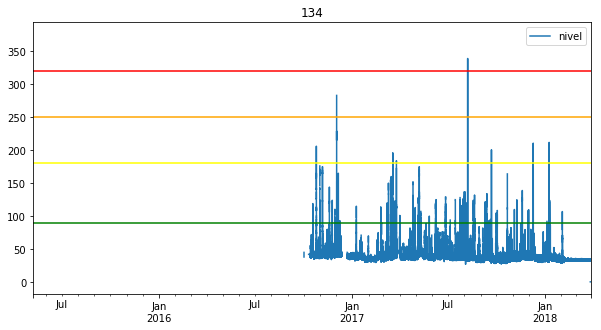

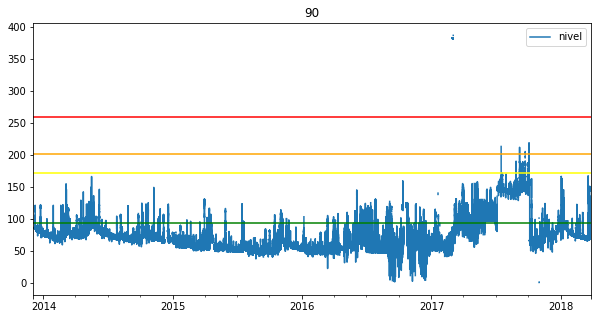

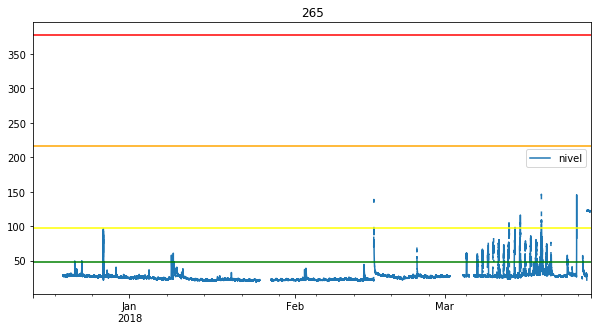

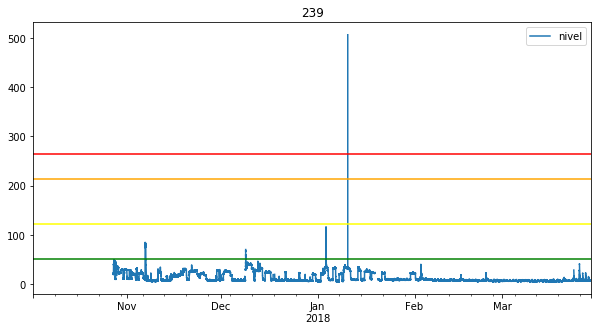

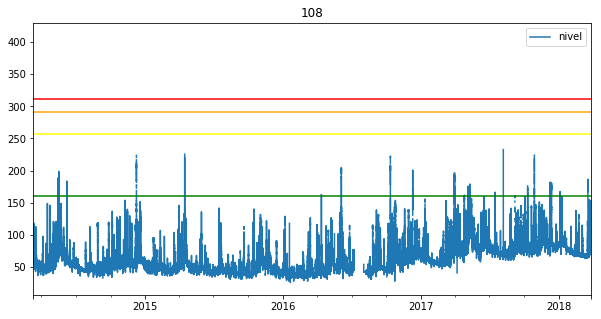

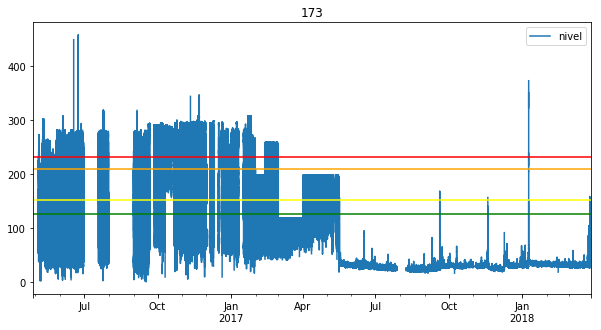

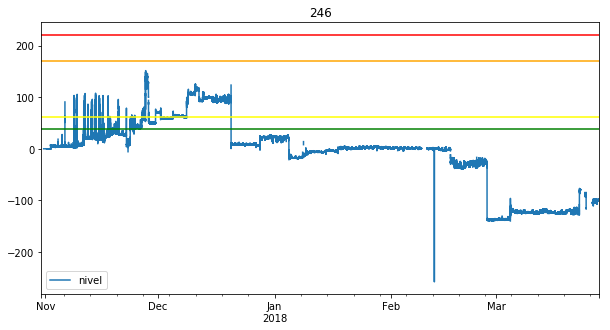

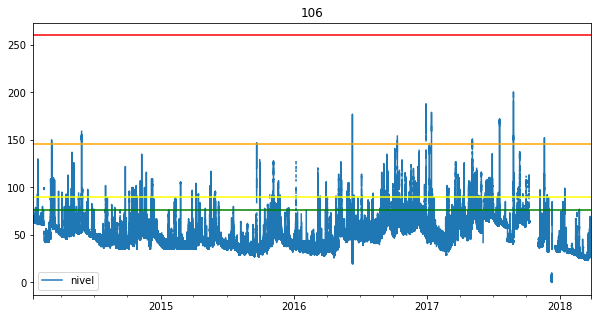

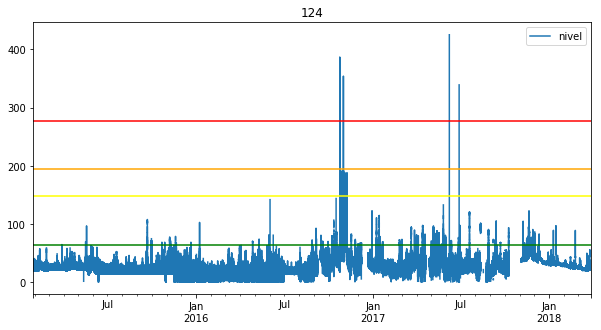

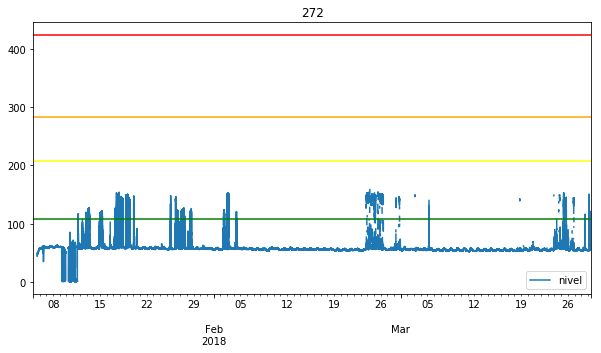

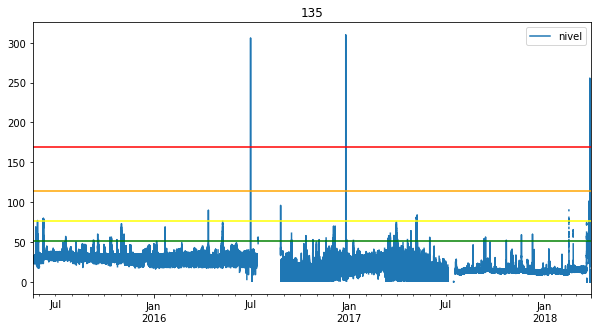

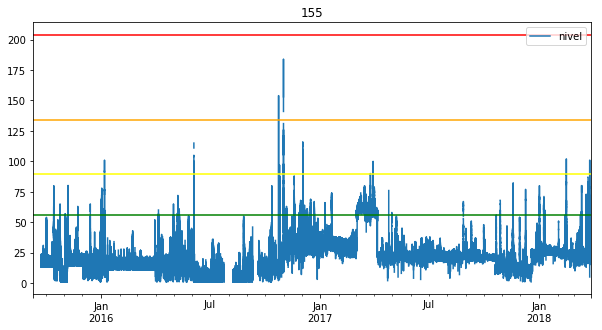

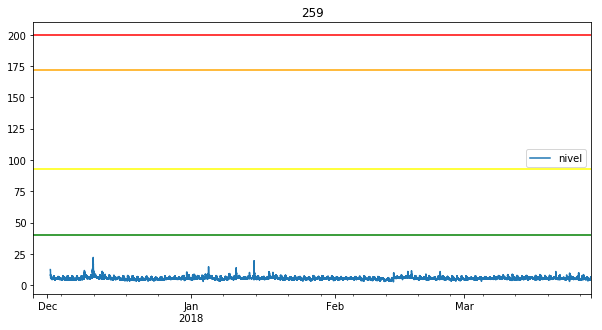

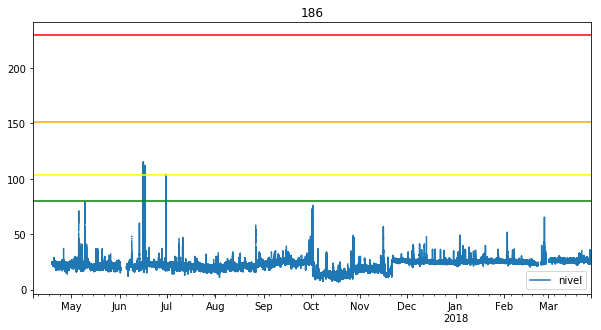

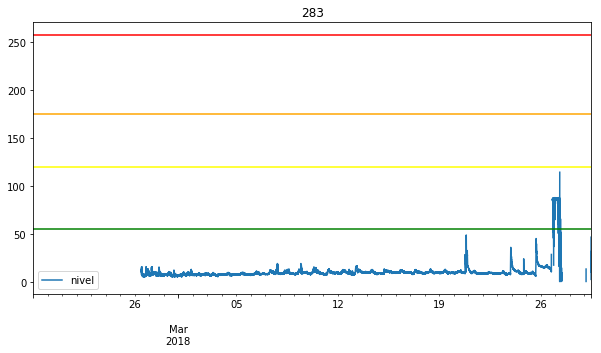

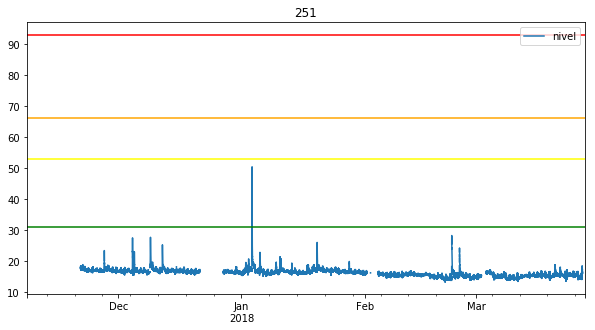

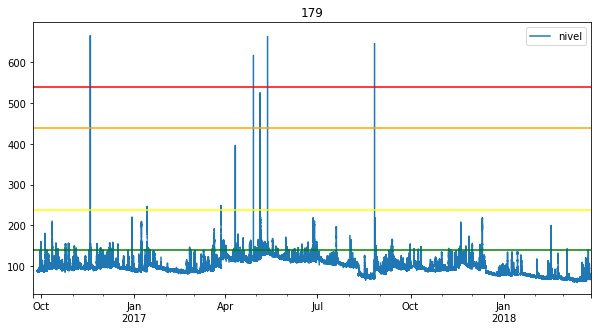

In [206]:
paths=glob.glob('historicos/nivel/*')
for path in np.sort(paths):
    est=int(path[-9:-6].split('/')[-1])
    #leer y organizar las series.
    nivel=pd.read_csv(path)
    nivel.index=pd.to_datetime(nivel[nivel.keys()[0]])#nivel[nivel.keys()[0]]
    nivel.index.name=''
    nivel=nivel.drop(nivel.keys()[0],axis=1)
    nivel.columns=['nivel']
    nrisk=np.array(risklevels_all[risklevels_all.index==est])[0]
    if est==246:
        pass
    else:
        nivel[nivel<=0]=np.nan
    nivel[nivel>nrisk[-1]*3]=np.nan
    pl.figure()
    nivel.plot(figsize=(10,5))
    colors=['g','yellow','orange','r']
    for index,i in enumerate(nrisk):
        pl.axhline(i,c=colors[index])
    pl.title(str(est))

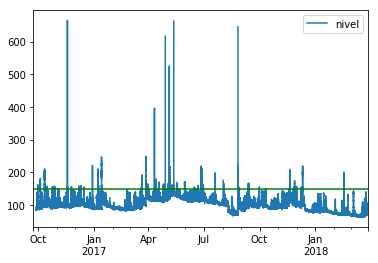

In [250]:
nivel.plot()
pl.axhline(nrisk[0]+10,c='g')

#### Separar eventos Niveles.

PARA TODAS LAS N DE INTERÉS.

In [216]:
sirenas=np.hstack(dfconfig.index)
sirenas=sirenas[np.where(sirenas)[0]]
print sirenas

infoestaciones = self.infost
risklevels_all=infoestaciones[['action_level','minor_flooding','moderate_flooding','major_flooding']]

timeperiod='3 hours'
paths_n={}
for path in glob.glob('/media/nicolas/Home/Jupyter/Soraya/git/Alarmas/04_web_hidrologia/hidrologia/historicos/nivel/*'):
    paths_n.update({path[-9:-6].split('/')[-1]:path})
paths_p={}
for path in glob.glob('/media/nicolas/Home/Jupyter/Soraya/git/Alarmas/04_web_hidrologia/hidrologia/historicos/pluvio/*'):
    paths_p.update({path[-9:-6].split('/')[-1]:path})
    

[u'216' u'219' u'220' u'221' u'222' u'223' u'224' u'226' u'279' u'280'
 u'285']


In [217]:
sir=sirenas[0]
sir

u'216'

In [218]:
str(np.hstack(dfconfig[dfconfig.index==sir]['EstNivel1']))

'[108]'

In [228]:
# for sir in sirenas:
est=int(np.hstack(dfconfig[dfconfig.index==sir]['EstNivel1']))
path=paths_n[str(est)]
#se lee y organiza la serie
nivel=pd.read_csv(path)
nivel.index=pd.to_datetime(nivel[nivel.keys()[0]])
nivel.index.name=''
nivel=nivel.drop(nivel.keys()[0],axis=1)
nivel.columns=['nivel']
nivel=nivel['nivel']
#nrisk
nrisk=np.array(risklevels_all[risklevels_all.index==est])[0]
umbralUP=nrisk[-1]*3
umbralEV=nrisk[0]
W_ahead=100
Ni=nivel
#Se separan eventos
Nima = np.ma.array(Ni.values, mask=Ni.values > umbralUP)
G = fs.FindMax(Nima, Ni.index.to_pydatetime(), umbralEV, BusquedaAdelante=W_ahead)
#Maximos en series de pandas
Ev = pd.Series(np.hstack(np.array(Nima[G])), index=Ni.index[G])
#numero de eventos.
print Ev.size
#se grafica y guardan hidrógrafas
MatrizN=[]
#     fig = pl.figure(figsize=(10,7))
#     ax = fig.add_subplot(111)
for p,i in enumerate(Ev.index):
    MatrizN.append(Ni[i - pd.Timedelta(timeperiod):i + pd.Timedelta(timeperiod)].values)
#         ax.plot(Ni[i - pd.Timedelta(timeperiod): i + pd.Timedelta(timeperiod)].values)
#     pl.grid()
#     pl.xlabel('Tiempo', size = 16)
#     pl.ylabel('Nivel $[m]$', size = 16)
#     ax.tick_params(labelsize = 14)

21


In [220]:
dfnivel=pd.DataFrame(MatrizN).T
dfnivel.columns=(map(str,Ev.index))
dfnivel.to_csv('historicos/nivel/eventos_'+str(est)+'.csv')

In [462]:
Nmax=pd.DataFrame(Ev)
Nmax.columns=['Nmax']
Nmax.to_csv('historicos/nivel/Nmax_'+str(est)+'.csv')

In [221]:
n_perc=pd.DataFrame([dfnivel.T.quantile(0.1),dfnivel.T.quantile(0.25),dfnivel.T.quantile(0.50),dfnivel.T.quantile(0.75),dfnivel.T.quantile(0.90)]).T
n_perc.to_csv('historicos/nivel/bandas_'+str(est)+'.csv')

#### Separar eventos Pacum- Hietogramas.

In [410]:
sir=sirenas[-1]
sir

u'285'

In [434]:
ests_p=np.append(np.hstack(dfconfig[dfconfig.index==sir]['EstPluvioAdentro']),np.hstack(dfconfig[dfconfig.index==sir]['EstPluvioAfuera']))
ests_p=ests_p[np.where(ests_p)[0]]

In [448]:
for est_p in ests_p:
    MatrizP=[];EvP=[];Pacum10=[];Pacum3=[];Pacum1=[];Pacum3h=[];Pmax3h=[]
    path=paths_p[est_p]
    #se lee y organiza la serie
    seriep=pd.read_csv(path)
    seriep.index=pd.to_datetime(seriep[seriep.keys()[0]])
    seriep.index.name=''
    seriep=seriep.drop(seriep.keys()[0],axis=1)
    seriep.columns=['pluvio']
    seriep=seriep['pluvio']
    for ev in Ev.index:
        #ev
        seriev=seriep[ev-pd.Timedelta(timeperiod):ev+pd.Timedelta(timeperiod)]
        #si mas del 40% son no  nan.
        if (seriev.dropna().size)/float(seriev.size) < 0.4:
            pass
        else:
            #si puede guarde los eventos, try porque las serie N y P no siempre coinciden.
            try:
                MatrizP.append(seriev.values)
                Pacum10.append(seriep[ev-pd.Timedelta('10 days'):ev].sum())
                Pacum3.append(seriep[ev-pd.Timedelta('3 days'):ev].sum())
                Pacum1.append(seriep[ev-pd.Timedelta('1 days'):ev].sum())
                Pacum3h.append(seriep[ev-pd.Timedelta('3 hours'):ev].sum())
                Pmax3h.append(seriep[ev-pd.Timedelta('3 hours'):ev].max())
                EvP.append(ev)
            except:
                pass

    #hietrogramas.
    dfpluvio=pd.DataFrame(MatrizP).T
    dfpluvio.columns=(map(str,EvP))
    dfpluvio.to_csv('historicos/pluvio/eventos_'+str(est_p)+'.csv')

    #bandas - acumulacionP
    dfpluvio=dfpluvio.fillna(method='ffill')
    Pbandas=pd.DataFrame([dfpluvio.cumsum().T.quantile(0.1),dfpluvio.cumsum().T.quantile(0.25),dfpluvio.cumsum().T.quantile(0.5),dfpluvio.cumsum().T.quantile(0.75),dfpluvio.cumsum().T.quantile(0.9)]).T
    Pbandas.to_csv('historicos/pluvio/bandas_'+str(est_p)+'.csv')

    Pacum=pd.DataFrame([Pacum3h,Pacum1,Pacum3,Pacum10,Pmax3h])
    Pacum.index=['Pacum3h','Pacum1','Pacum3','Pacum10','Pmax3h']
    Pacum.columns=(map(str,EvP))
    Pacum.to_csv('historicos/pluvio/Pacum_'+str(est_p)+'.csv')

### Figuras

Cosas que deben ir en el cron

In [655]:
timedeltaEv=1#min
# label time
hours=np.arange(-3,4)
rng1=[]
for i in range(hours.size):
    if hours[i]<0:
        rng1.append('-0'+str(np.abs(hours[i]))+':00')
    else:
        rng1.append('0'+str(np.abs(hours[i]))+':00')
rng1=np.array(rng1)

Lectura de info antes de graficar.

In [572]:
#Rutas
ruta_estadistico='/media/nicolas/Home/Jupyter/Esneider/modelo_crecidas/pronostico_niveles.bin'
rutaN='historicos/nivel/'
rutafigs='results/graficas_op/'

Cada gráfrica se corre en for's aparte

In [449]:
# np.hstack(dfconfig['EstNivel1'])

array([155, 108, 173, 116, 259, 186, 135, 106, 246, 239, 134, 272])

    Nivel para las ppales - por ahora.

In [570]:
est=int(np.hstack(dfconfig[dfconfig.index==sir]['EstNivel1']))

In [573]:
#Estadistico
code=est
#ESTADISTICO
# se lee la info del pronostico 30m
f=open(ruta_estadistico)
n_pronos=pickle.load(f)
f.close()

n_pronos=pd.DataFrame(n_pronos)

#si la estacion tiene modelo estadistico
if float(code) in map(int,n_pronos[0]):
    columns=['codigo','n30p25','n30p50','n30p75','Ttop25','Ttop50','Ttop75']
    n_pronos.columns=columns
    n_pronos['codigo']=map(int,n_pronos['codigo'])
    n_pronos.index=n_pronos['codigo']
    n_pronos=n_pronos.drop('codigo',axis=1)
    n_pronos=n_pronos.T

#         if n_pronos[code].all() == 0:
    #si todos los pronosticos son cero
    if n_pronos[code].all() != 0:
        na=n_pronos[code]['n30p25'];nb=n_pronos[code]['n30p50'];nc=n_pronos[code]['n30p75']
        ta=n_pronos[code]['Ttop25'];tb=n_pronos[code]['Ttop50'];tc=n_pronos[code]['Ttop75']
    else:
    #grafique estos valores por ahora.
        na=0;nb=0;nc=0
        ta=0;tb=0;tc=0

#eventos.
Nmax=pd.read_csv(rutaN+'Nmax_'+str(est)+'.csv')
df=Nmax
df.index=pd.to_datetime(df[df.keys()[0]])
df.index.name=''
Nmax=df.drop(df.keys()[0],axis=1)

#hidrografas
Neventos=pd.read_csv(rutaN+'eventos_'+str(est)+'.csv')
# Neventos[Neventos.keys()[1:]]
#bandasN
Nbandas=pd.read_csv(rutaN+'bandas_'+str(est)+'.csv')
# Nbandas[['0.1','0.9']]

In [574]:
#consulta ultimas 3 horas.
self= cpr.Nivel(est)
start=(dt.datetime.now()-pd.Timedelta('3 hours')).strftime('%Y-%m-%d-%H:%M')
end=dt.datetime.now().strftime('%Y-%m-%d-%H:%M')
level=self.get_level(start,end)
# level=(level['nivel'].resample('5T').mean()/100.0)
level=level['nivel']

----------

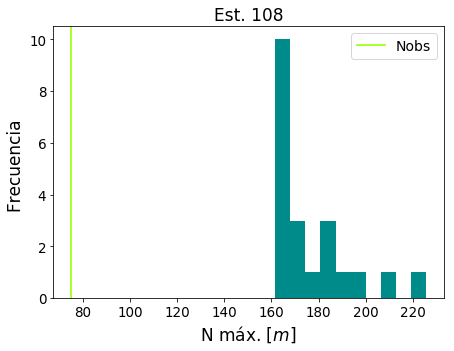

In [575]:
fig=pl.figure(figsize=(7,5))
ax=fig.add_subplot(111)
pl.hist(Nmax['Nmax'],color='darkcyan')
pl.axvline(level[-1],c='greenyellow',lw=2,label='Nobs')
if nb==0:
    pass
else:
    pl.axvline(nb,c='greenyellow',lw=2,label=u'Nmáx_30',ls='--')
ax.set_title('Est. '+ str(est),fontsize=17)
ax.set_ylabel('Frecuencia ', size= 17)
ax.set_xlabel(u'N máx. $[m]$', size= 17)
ax.tick_params(labelsize=13.5)
ax.legend(fontsize=14)
pl.savefig(rutafigs+'Nhist/Nhist_'+str(est)+'.png')

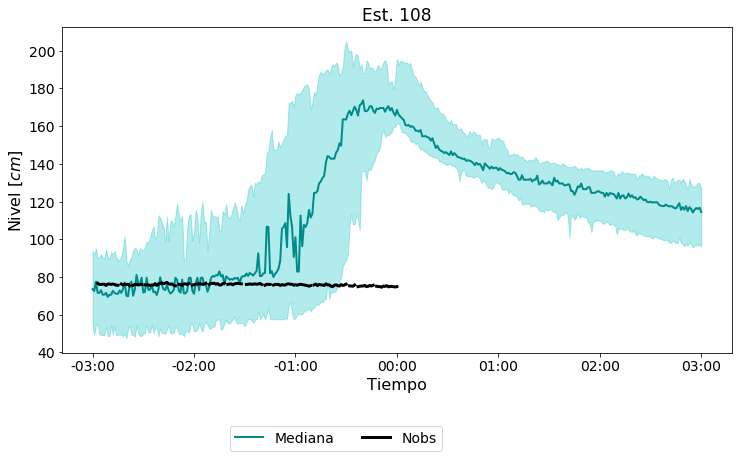

In [679]:

#plot
fig=pl.figure(figsize=(12,6))
ax=fig.add_subplot(111)
# for p,i in enumerate(.index):
#     ax.plot(Ni[i - tm: i + tm].values, color='lightgray')
#
# ax.plot(Neventos[Neventos.keys()[1:]],c='lightgray')
ax.fill_between(np.arange(Nbandas['0.1'].size),Nbandas['0.1'],Nbandas['0.9'], color = 'c', alpha = 0.3)
#ax.plot(Nbandas[['0.1']],color='darkcyan',label='$P_{10}$',ls='--',lw=2)
#ax.plot(Nbandas[['0.9']],color='darkcyan',label='$P_{99}$',ls='--',lw=2)
ax.plot(Nbandas['0.5'],color='darkcyan',label='Mediana',lw=2) #'yeloowgreen.
ax.plot(level.values,c='k',lw=3,label='Nobs')
if nb==0:
    pass
else:
    pl.scatter(level.size+((60/timedeltaEv)/2),nb,c='crimson',marker='*',s=150,label=u'Nmáx30')
ax.set_title('Est. '+ str(est),fontsize=17)
ax.set_ylabel('Nivel $[cm]$', size= 16)
ax.set_xlabel('Tiempo', size= 16)
ax.tick_params(labelsize=14)
ax.set_xticks(np.arange(0,Neventos.shape[0],60/timedeltaEv))
ax.set_xticklabels(rng1)
# ax.grid()
ax.legend(fontsize=14,loc=(0.25,-0.30),ncol=3)
pl.savefig(rutafigs+'Nshape/Nshape_'+str(est)+'.png')

#### Pluvio

In [629]:
#rutas
ruta_pluvioforecast='/media/nicolas/Home/Jupyter/Esneider/Lluvia_operacional/Salidas/'
rutaP='historicos/pluvio/'

In [668]:
#bandas
Pbandas=pd.read_csv(rutaP+'bandas_'+str(est_p)+'.csv')
#Pacum
Pacum=pd.read_csv(rutaP+'Pacum_'+str(est_p)+'.csv')
Pacum.index=Pacum[Pacum.keys()[0]]
Pacum=Pacum.drop(Pacum.keys()[0],axis=1)

#pluvioforecast
f = open(ruta_pluvioforecast+'_cast_normal.rain','r')
cast_normal = pickle.load(f)
f.close()
#cast_normal[str(est_p)]

#consulta
start=(dt.datetime.now()-pd.Timedelta('10 days')).strftime('%Y-%m-%d-%H:%M')
end=dt.datetime.now().strftime('%Y-%m-%d-%H:%M')
self = cpr.Pluvio(est_p)
pluvio = self.read_pluvio(start,end)

In [688]:
P3h=pluvio[pd.to_datetime(end)-pd.Timedelta('3 hours'):][:-1]
Pacum1d=pluvio[pd.to_datetime(end)-pd.Timedelta('1 days'):][:-1].sum()
Pacum3d=pluvio[pd.to_datetime(end)-pd.Timedelta('3 days'):][:-1].sum()
Pacum10d=pluvio[pd.to_datetime(end)-pd.Timedelta('10 days'):][:-1].sum()

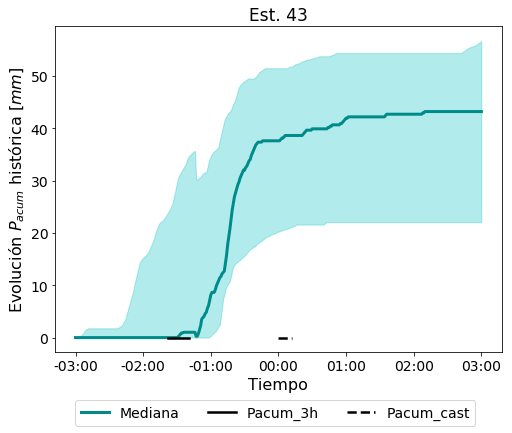

In [681]:
P=P3h.append(cast_normal[str(est_p)])
fig=pl.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.fill_between(np.arange(Pbandas['0.1'].size),Pbandas['0.1'],Pbandas['0.9'], color = 'c', alpha = 0.3)
ax.plot(Pbandas['0.5'],color='darkcyan',label='Mediana',lw=3)
ax.plot(np.arange(0,P3h.size),P[:P3h.size].values,c='k',lw=2.5,label='Pacum_3h')
ax.plot(np.arange(P3h.size,P.size),P[P3h.size:].values,c='k',lw=2.5,ls='--',label='Pacum_cast')
ax.set_ylabel(u'Evolución $P_{acum}$ histórica $[mm]$', size= 16)
ax.set_xlabel('Tiempo', size= 16)
ax.set_title('Est. '+ str(est_p),fontsize=17)
ax.tick_params(labelsize=14)
ax.set_xticks(np.arange(0,Neventos.shape[0],60/timedeltaEv))
ax.set_xticklabels(rng1)
ax.legend(fontsize=14,loc=(0.045,-0.225),ncol=3)
pl.savefig(rutafigs+'Pshape_'+str(est)+'.png')

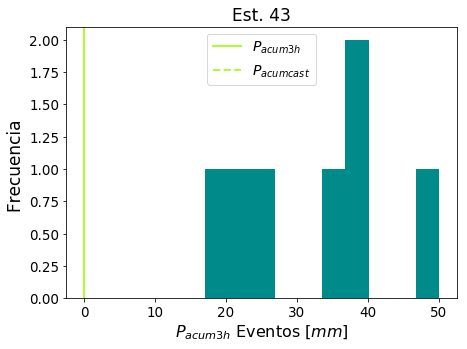

In [692]:
fig=pl.figure(figsize=(7,5))
ax=fig.add_subplot(111)
pl.hist(np.array(Pacum[Pacum.index=='Pacum3h'])[0],color='darkcyan')
pl.axvline(P3h.sum(),c='greenyellow',lw=2,label='$P_{acum3h}$')
pl.axvline(P.sum(),c='greenyellow',lw=2,label=u'$P_{acumcast}$',ls='--')
ax.set_ylabel('Frecuencia ', size= 17)
ax.set_xlabel(u'$P_{acum3h}$ Eventos $[mm]$', size= 16)
ax.set_title('Est. '+ str(est_p),fontsize=17)
ax.tick_params(labelsize=13.5)
ax.legend(fontsize=14)
pl.savefig(rutafigs+'Phist_'+str(est)+'.png')

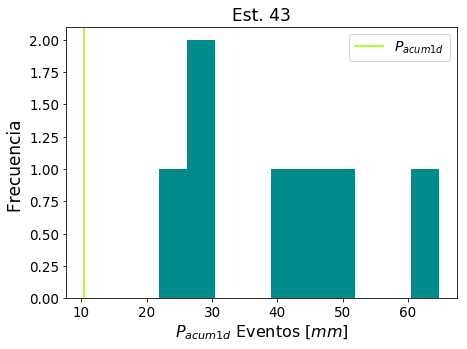

In [696]:
fig=pl.figure(figsize=(7,5))
ax=fig.add_subplot(111)
pl.hist(np.array(Pacum[Pacum.index=='Pacum1'])[0],color='darkcyan')
pl.axvline(P1d.sum(),c='greenyellow',lw=2,label='$P_{acum1d}$')
#pl.axvline(P.sum(),c='greenyellow',lw=2,label=u'$P_{acumcast}$',ls='--')
ax.set_ylabel('Frecuencia ', size= 17)
ax.set_xlabel(u'$P_{acum1d}$ Eventos $[mm]$', size= 16)
ax.set_title('Est. '+ str(est_p),fontsize=17)
ax.tick_params(labelsize=13.5)
ax.legend(fontsize=14)
pl.savefig(rutafigs+'Phist_'+str(est)+'.png')

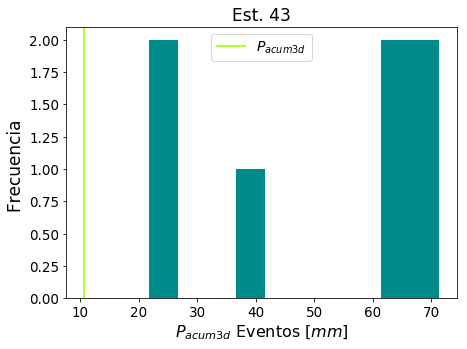

In [699]:
fig=pl.figure(figsize=(7,5))
ax=fig.add_subplot(111)
pl.hist(np.array(Pacum[Pacum.index=='Pacum3'])[0],color='darkcyan')
pl.axvline(P3d.sum(),c='greenyellow',lw=2,label='$P_{acum3d}$')
#pl.axvline(P.sum(),c='greenyellow',lw=2,label=u'$P_{acumcast}$',ls='--')
ax.set_ylabel('Frecuencia ', size= 17)
ax.set_xlabel(u'$P_{acum3d}$ Eventos $[mm]$', size= 16)
ax.set_title('Est. '+ str(est_p),fontsize=17)
ax.tick_params(labelsize=13.5)
ax.legend(fontsize=14)
pl.savefig(rutafigs+'Phist_'+str(est)+'.png')

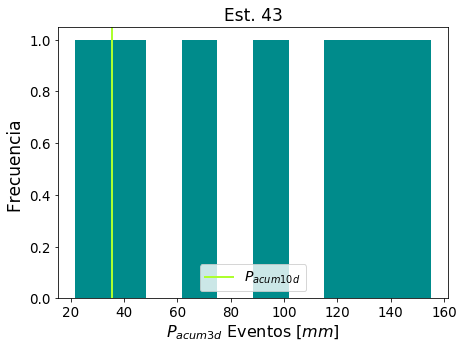

In [700]:
fig=pl.figure(figsize=(7,5))
ax=fig.add_subplot(111)
pl.hist(np.array(Pacum[Pacum.index=='Pacum10'])[0],color='darkcyan')
pl.axvline(P10d.sum(),c='greenyellow',lw=2,label='$P_{acum10d}$')
#pl.axvline(P.sum(),c='greenyellow',lw=2,label=u'$P_{acumcast}$',ls='--')
ax.set_ylabel('Frecuencia ', size= 17)
ax.set_xlabel(u'$P_{acum3d}$ Eventos $[mm]$', size= 16)
ax.set_title('Est. '+ str(est_p),fontsize=17)
ax.tick_params(labelsize=13.5)
ax.legend(fontsize=14)
pl.savefig(rutafigs+'Phist_'+str(est)+'.png')